In [1]:
%%capture

import jax.numpy as jnp
import numpy as np
import pandas as pd
import d3p
import numpyro
import numpyro.distributions as dists
from twinify.dpvi import DPVIModel, DPVIResult
import seaborn as sns
import matplotlib.pyplot as plt

from twinify.dpvi.modelling import slice_feature
import jax.numpy as jnp


#### Generating an example data set

We first generate a simple data set of size $N$ where each data point $\mathbf{x}$ is sampled from a mixture of one of two Gaussians, depending on a known indicator variable $z$.

In [2]:
# set up some mean and covariances for the two Gaussians that make up the mixture
num_dims = 2
means = np.array([
    [-2, -2],
    [ 1,  1]
])
covariances = np.array([
    [
        [.6, .4],
        [.4, .9]
    ],
    [
        [2., 0.],
        [0., 1.]
    ]
])
chol_covariances = np.array([np.linalg.cholesky(cov) for cov in covariances])

center_sample_counts = np.array([200, 800])
assignments = np.concatenate((np.zeros(center_sample_counts[0], dtype=np.int32), np.ones(center_sample_counts[1], dtype=np.int32)))
rs = np.random.RandomState(826935)
xs = rs.randn(center_sample_counts.sum(), num_dims) 

xs[:center_sample_counts[0]] = xs[:center_sample_counts[0]] @ chol_covariances[0] + means[0]
xs[center_sample_counts[0]:] = xs[center_sample_counts[0]:] @ chol_covariances[1] + means[1]

orig_df = pd.DataFrame(xs, columns=["first_dimension", "second_dimension"])
orig_df['assignments'] = assignments
orig_df

,first_dimension,second_dimension,assignments
0,-4.190167,-3.666270,0
1,-1.294340,-2.099514,0
2,-1.078206,-1.104915,0
3,-2.576338,-0.579721,0
4,-3.374816,-2.171204,0
...,...,...,...
995,2.333329,0.871575,1
996,-0.182534,-0.388142,1
997,0.481779,-0.595240,1
998,0.928569,1.943616,1


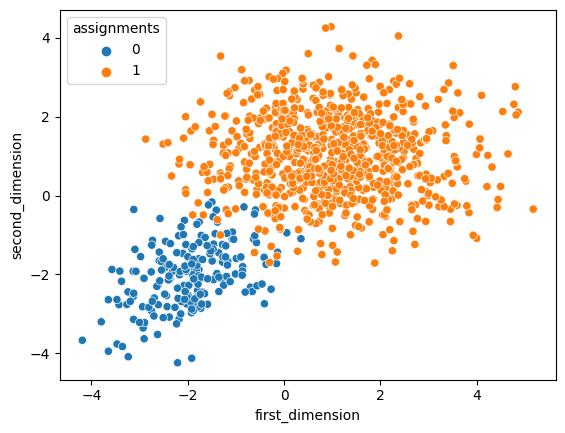

In [3]:
sns.scatterplot(x=orig_df['first_dimension'], y=orig_df['second_dimension'], hue=orig_df['assignments'])
plt.show()

#### Creating a NumPyro model function

For twinify's DPVI mode, we now need to specify a probabilistic model, which will be fit to the data and which we can later use to generate the synthetic twin. We need to specify join distribution over parameters and observations, which we split into a parameter prior $p(\mathbf{\theta})$ and a data likelihood conditioned on parameter values $p(\mathbf{x},z|\mathbf{\theta})$. The likelihood part follows exactly the mixture model we used to generate the example data above:

$ p(\mathbf{x},z|\theta) = p(z=0|\pi) \mathcal{N}(\mathbf{x}|\mu_0, \Sigma_0) + p(z=1|\pi) \mathcal{N}(\mathbf{x}|\mu_1, \Sigma_1). $

Additionally, we define the following prior:

$ \pi \sim \text{Beta}(1, 1), $

$ \mathbf{\mu}_i \sim \mathcal{N}(0, \mathbf{I}_2), $

$ \Sigma_i = \mathbf{s}_i C_i \text{, where } \mathbf{s}_i \sim \Gamma(1), C_i \sim \text{LKJ}(2, 1.). $

Below is this model expressed as a NumPyro model function:

In [4]:

def model(xs = None, num_obs_total = None):
    """ Model function; specifies the joint distribution of parameters and observations.

    Args:
        xs (jax.numpy.ndarray): A batch of observations / training data during inference. None during data generation.
        num_obs_total (int): The size of the training data set during inference. None during data generation.
    """
    batch_size = 1
    if xs is not None:
        batch_size = jnp.shape(xs)[0]
    if num_obs_total is None:
        num_obs_total = batch_size

    num_mixture_components = 2

    # prior
    assignment_probability = numpyro.sample("assignment_p", dists.Beta(1., 1.))
    component_correlations = numpyro.sample("correlations", dists.LKJCholesky(num_dims, 1.), sample_shape=(num_mixture_components,))
    component_marginal_stddevs = numpyro.sample("stddevs", dists.Gamma(1), sample_shape=(num_mixture_components, num_dims))
    component_means = numpyro.sample("means", dists.MultivariateNormal(jnp.zeros(num_dims), jnp.eye(num_dims)), sample_shape=(num_mixture_components,))

    component_scale_tril = component_marginal_stddevs * component_correlations

    # likelihood
    with numpyro.plate("observations", num_obs_total, batch_size):
        if xs is not None:
            assignments = slice_feature(xs, -1).flatten().astype(np.int8)
        else:
            assignments = None

        assignments = numpyro.sample("assignment", dists.Bernoulli(assignment_probability), obs=assignments)

        # the input parameter xs contains the variables x and z of our model, laid out as [x dim 0, x dim 1, z].
        # twinify's slice_features method allows us to extract only the two dimensions corresponding to variable x.
        # Compared to manual slicing, slice_features deals gracefully with the case that xs may be None during data generation.
        xs = numpyro.sample("xs",
                            dists.MultivariateNormal(component_means[assignments], scale_tril=component_scale_tril[assignments]),
                            obs=slice_feature(xs, 0, num_dims)
        )

    # As opposed to regular NumPyro models, twinify expects model functions to return the generated data as a single array
    # with the same layout as the input.
    return jnp.hstack((xs, jnp.expand_dims(assignments, -1)))


#### Learning the Model's Parameters with Privacy Guarantees

With our model function now defined, we create a `DPVIModel` class from it and invoke the privacy-preserving inference with privacy parameters $\epsilon = 2$ and $\delta = 1/N^2$. The inference requires a key to extract randomness from as the second argument, which we construct using `d3p.random.PRNGKey()` without arguments, which obtains a secure random key from the system (using the `secrets` module).

In [5]:
dpvi_model = DPVIModel(model)
dpvi_posterior = dpvi_model.fit(orig_df, d3p.random.PRNGKey(), epsilon=2.0, delta=len(orig_df)**(-2))

epochs: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.34it/s, ELBO 3.855]


#### Sampling Synthetic Data

We have obtained a distribution over model parameters, wrapped handily in a `DPVIResult` object. This allows us to easily sample a new data set that will follow the same distribution as the original data. This method also requires a randomness key. Here we provide a seed to `d3p.random.PRNGKey(1)` which allows us to reproduce the draw of random data from the model if we should require to later on (by providing the same key again).

In [6]:
syn_data = dpvi_posterior.generate(d3p.random.PRNGKey(1), 1000)
syn_data

,first_dimension,second_dimension,assignments
0,2.868792,1.538933,1
1,1.821906,1.473201,1
2,0.621885,0.464806,1
3,1.782785,0.753955,1
4,0.234708,1.131520,1
...,...,...,...
995,1.503803,1.322465,1
996,0.320501,0.052667,1
997,0.210984,-0.268047,1
998,1.067145,1.022880,1


#### Comparing the Synthetic Data to the Original Data

We perform a quick visual exploration of the quality of the synthetic data by first plotting a scatter plot overlaid on that of the original data, which shows that the synthetic data is indeed following the distribution of the original data closely.

We also plot the number of data points assigned to each cluster further below and verify that they match between synthetic and original data.

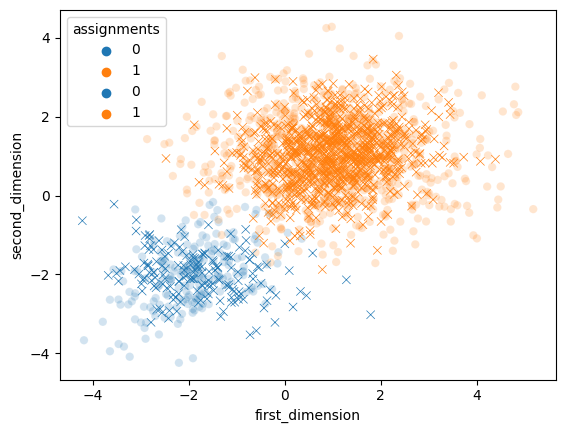

In [7]:
sns.scatterplot(x=orig_df['first_dimension'], y=orig_df['second_dimension'], hue=orig_df['assignments'], alpha=.2)
sns.scatterplot(x=syn_data['first_dimension'], y=syn_data['second_dimension'], hue=syn_data['assignments'], marker='x')
plt.show()


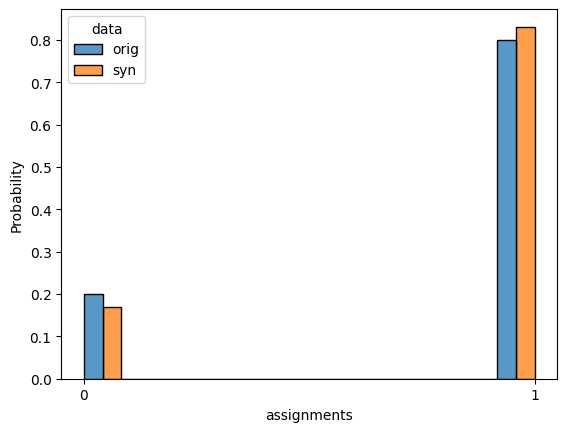

In [8]:
component_assignments = pd.concat((
    pd.DataFrame({'assignments': orig_df['assignments'], 'data': 'orig'}),
    pd.DataFrame({'assignments': syn_data['assignments'], 'data': 'syn'})
))
ax = sns.histplot(component_assignments, x="assignments", hue='data', stat='probability', multiple='dodge', common_norm=False)
ax.set_xticks([0, 1])
plt.show()

#### Storing and Loading the Learned Model

twinify enables us to store the inferred parameters for later use. However, as the model function as such cannot be easily persisted, it is the user's responsibility to make it available during loading of the model:

In [9]:
dpvi_posterior.store("twinify_result")
loaded_posterior = DPVIResult.load("twinify_result", model=model)

# with the loaded model we can again generate data; using the same randomness as before, we can re-produce the same data set
syn_data_from_loaded_posterior = loaded_posterior.generate(d3p.random.PRNGKey(1), 1000)
assert np.all(syn_data_from_loaded_posterior == syn_data)